# ISIS3301 - Inteligencia de Negocios

## Proyecto 1 - Clasificación de textos (2025-20)

Estudiante 1: - Maria Jose Mantilla 202121670 (Regresión logística)

Estudiante 2: - María Inés Velásquez 202224325 (Multinomial Naïve Bayes)

Estudiante 3: - Gabriela Zambrano 202211712 (K-vecinos)

# Problema

El UNFPA quiere clasificar las opiniones de los ciudadanos en las diferentes categorías de los ODS, específicamente los ODS 1, 3 y 4. Para ello, quiere utilizar un modelo de clasificación supervisado.

# 1. Importación de librerías

Para realizar este proyecto s eimportan diferentes librerías con el fin de ayudar a procesar los datos y entrenar los modelos.

In [44]:
# librería para manejar las flexiones gramaticales en el idioma español.
#!pip install inflect-es
# Manejo de gráficas
#!pip install scikit-plot

In [45]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [46]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install ydata-profiling

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier


from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
from google.colab import drive
!pip install num2words
from num2words import num2words

!python -m spacy download es_core_news_sm
import spacy

from scipy import stats as st
from collections import Counter

from ydata_profiling import ProfileReport
from google.colab import files
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 55.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 2. Perfilamiento y entendimiento de los Datos

## Lectura de datos


Primero se cargan los datos para poder trabajar sobre ellos y se analiza que tipo de forma tienen, cuántas columnas, que tipo de datos tienen estas columnas con el fin de entenderlos para poder utilizarlos más adelante.

In [49]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

drive.mount('/content/drive')
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/BI/Datos_proyecto.xlsx")


# Asignación a una nueva variable de los datos leidos
data_t=data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data_t

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1
2422,"Sin embargo, estas fallas del mercado implican...",3


In [51]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


Como se puede observar, los datos se componen de 2424 elementos, con dos columnas el texto en String y una etiqueta numerica. No se observan datos faltantes.

# 3. Preparación de los datos

Ahora bien, se realiza una preparación de los datos para que sea más sencillo implementar los modelos de clasificación. En primer lugar se realiza una copia de los datos para evitar cambiar los originales y con esta copia se calculan algunas medidas como la cantidad de palabras en cada texto ("Conteo"), la palabra más frecuente de cada texto ("Moda"), la longitud máxima de las palabras de cada texto ("Max") y  la mínima ("Min"). Esto permite entender mejor el tamaño de los datos.

In [52]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['textos']]
textos['Moda'] = [Counter(i.split()).most_common(1)[0][0] for i in textos['textos']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['textos']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['textos']]


Después se genera un reporte que para identificar tendencias utilizando las estadísticas calculadas anteriormente. COn lo cual se observan las palabras más frecuentes, el imbalance entre clases, la cantidad de clases para clasificar, etc.

In [53]:
# Crear el reporte
profile = ProfileReport(textos)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00,  9.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
textos

,textos,labels,Conteo,Moda,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,de,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,y,16,1
2,"Además, la formación de especialistas en medic...",3,659,de,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,de,18,1
4,Este grupo se centró en las personas que padec...,3,608,de,14,0
...,...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,741,de,16,1
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,541,de,15,1
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,352,el,12,1
2422,"Sin embargo, estas fallas del mercado implican...",3,754,el,15,1


## 3.1 Limpieza de los datos

Después, se realiza una limpieza de los datos que consiste en estandarizar los textos, es decir, normaliza las palabras manteniendo tíldes, convierte todas las palabras en mínusculas para evitar diferencias innecesarias, eliminar los signos de puntuación, reemplazar los números por palabras y eliminar stopword que son palabras frecuentes como artículos que en este caso no aportan significado al modelo. Esto permite reducir las dimensiones de los datos y mejorar el modelo al utilizar solo información importante. A continuación se muestran las funciones utilizadas para limpiar y preprocesar los datos.

In [55]:
def remove_non_ascii(words):
    "Quitar caracteres no ASCII pero manteniendo letras con acentos"
    new_words = []
    for word in words:
        if word is not None:
            # Normaliza pero mantiene tildes
            new_word = unicodedata.normalize('NFC', word)
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    "Convertir a minúsculas"
    return [word.lower() for word in words if word is not None]

def remove_punctuation(words):
    "Eliminar signos de puntuación"
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\wáéíóúñüÁÉÍÓÚÑÜ]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
    "Reemplazar números por palabras en español"
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = num2words(int(word), lang='es')
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    "Eliminar stopwords en español"
    stops = set(stopwords.words('spanish'))
    return [word for word in words if word not in stops]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

## 3.2 Tokenización

Para empezar con la limpieza de los textos, es necesario separar los mismos en tokens, es decir componentes como palabras, puntuación, etc, para tratar estas por individual y faciliatar la eliminación de riudo innecesario. En este caso se cre+o una nueva columna para observar las diferencias.

In [56]:
data_t['words'] = data_t['textos'].apply(word_tokenize)
data_t.head()

,textos,labels,words
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q..."


In [57]:
data_t['words'].dropna()

,words
0,"[``, Aprendizaje, '', y, ``, educación, '', se..."
1,"[Para, los, niños, más, pequeños, (, bebés, y,..."
2,"[Además, ,, la, formación, de, especialistas, ..."
3,"[En, los, países, de, la, OCDE, se, tiende, a,..."
4,"[Este, grupo, se, centró, en, las, personas, q..."
...,...
2419,"[La, tutoría, de, carrera, está, diseñada, par..."
2420,"[Fuente, :, Ministerio, de, Educación, ., Las,..."
2421,"[Y, desde, 2010, ,, el, PNUD, ha, sido, pioner..."
2422,"[Sin, embargo, ,, estas, fallas, del, mercado,..."


In [58]:
data_t.shape

(2424, 3)

In [59]:
data_t['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2424 entries, 0 to 2423
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
2424 non-null   object
dtypes: object(1)
memory usage: 19.1+ KB


In [60]:
data_t['words1']=data_t['words'].apply(preprocessing) #Aplica la eliminación del ruido
data_t.head()

,textos,labels,words,words1
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...","[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...","[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


Después de haber tokenizado y preprocesado los datos se cuenta con una columna en donde se encuentran listas con palabras importantes para el modelo.

## 3.3 Normalización

Con la información preprocesada, se busca normalizar las palabras con el fin de reducir dimensionalidad. Es decir, para evitar tener verbos en diferentes tiempos, sustantivos en diferentes géneros, etc. Se utilizó una lematización de las palabras, que identifica la palabra más general para representar esos casos. Por ejemplo, niña, niño, niñas y niños se lematizan en niño. En este caso no se uso stemming debido a que no aportaba significado al modelo e incluso podría generar errores al encontrar raíces como beb para bebé o para beber, lo que indica que encuentra raíces para las palabras, pero estas pierden el significado.

In [61]:
nlp = spacy.load("es_core_news_sm")

def lemmatize(words):
    """Lematización en español con spaCy"""
    doc = nlp(" ".join(words))
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return lemmas

data_t['words2'] = data_t['words1'].apply(lemmatize)
data_t.head()

,textos,labels,words,words1,words2
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...","[además, formación, especialistas, medicina, g...","[además, formación, especialista, medicín, gen..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


## 3.4 Selección de campos

Finalmente, para seleccionar los campos que se utilizarán para entrenar el modelo y que este sea más confiable, se juntan las palabras lematizadas en una sola cadena de texto.

In [62]:
data_t['words3'] = data_t['words2'].apply(lambda x: ' '.join(map(str, x)))
data_t

,textos,labels,words,words1,words2,words3
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ...",aprendizaje educación considerar sinónir escol...
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac...",niño pequeño bebé niño pequeño capacitación es...
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...","[además, formación, especialistas, medicina, g...","[además, formación, especialista, medicín, gen...",además formación especialista medicín general ...
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio...",país ocde tender pasar curso obligatorio optat...
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ...",grupo centrar persona padecer trastorno mental...
...,...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,"[La, tutoría, de, carrera, está, diseñada, par...","[tutoría, carrera, diseñada, apoyar, estudiant...","[tutoer, carrera, diseñado, apoyar, estudiant,...",tutoer carrera diseñado apoyar estudiant conse...
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,"[Fuente, :, Ministerio, de, Educación, ., Las,...","[fuente, ministerio, educación, tasas, interna...","[fuente, ministerio, educación, tasa, interno,...",fuente ministerio educación tasa interno retor...
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,"[Y, desde, 2010, ,, el, PNUD, ha, sido, pioner...","[dosmildiez, pnud, sido, pionero, puesta, marc...","[dosmildiez, pnud, ser, pionero, puesta, march...",dosmildiez pnud ser pionero puesta marcha pres...
2422,"Sin embargo, estas fallas del mercado implican...",3,"[Sin, embargo, ,, estas, fallas, del, mercado,...","[embargo, fallas, mercado, implican, competenc...","[embargo, fal él, mercado, implicar, competenc...",embargo fal él mercado implicar competencia so...


Para que los modelos puedan entender los textos se transforman en un formato númerico. Es decir, se vectorizan estos con el método TF-IDF, que permite calcular la imprtancia de la palabra de acuerdo a las veces que aparece en un texto, pero considerando también las veces que aparece en los demás textos. Por lo tanto se obtiene un valor más objetivo, dandole más valor a las palabras que aportan información. Por ello, al final se crea un DataFrame cuyas columnas solo tendrán palabras con una importancia mayor a cero y cuyas filas son los documentos, con el fin de entrenar los modelos con unos datos significativos.

In [63]:
tfidf = TfidfVectorizer()
X_tf_idf = tfidf.fit_transform(data_t['words3'])

print(X_tf_idf.shape)

# Obtener los nombres de las palabras (features)
words = tfidf.get_feature_names_out()

# Tomar el primer documento (índice 0)
vector = X_tf_idf[0].toarray()[0]

# Crear un DataFrame solo con los términos que tienen peso > 0
df = pd.DataFrame({
    'word': words,
    'tfidf': vector
})
df = df.sort_values(by="tfidf", ascending=False)

print(df)

(2424, 11228)
              word     tfidf
7907  organización  0.321658
9967       sinónir  0.295311
4710   examinadora  0.295311
2744    considerar  0.276312
4055     editorial  0.270042
...            ...       ...
3746        dispar  0.000000
3747      disparar  0.000000
3748    disparidad  0.000000
3749  disparidades  0.000000
3739   disminución  0.000000

[11228 rows x 2 columns]


Finalmente se separan los datos, en las características para realizar la clasificación y las etiquetas.

In [64]:
X_data, y_data = data_t['words3'],data_t['labels']
y_data

,labels
0,4
1,4
2,3
3,4
4,3
...,...
2419,4
2420,4
2421,1
2422,3


In [65]:
X_data

,words3
0,aprendizaje educación considerar sinónir escol...
1,niño pequeño bebé niño pequeño capacitación es...
2,además formación especialista medicín general ...
3,país ocde tender pasar curso obligatorio optat...
4,grupo centrar persona padecer trastorno mental...
...,...
2419,tutoer carrera diseñado apoyar estudiant conse...
2420,fuente ministerio educación tasa interno retor...
2421,dosmildiez pnud ser pionero puesta marcha pres...
2422,embargo fal él mercado implicar competencia so...


# 4. Modelos de clasificación

##4.1 División Datos

Para hacer el entrenamiento de los modelos de clasificación se decide hacer en primer lugar la división de los datos en train y test. Realizando una división de 75% train 25% test.   

In [66]:
#Hacer division de datos en test y train, no se si toca hacer una copia de los datos o si se puedan usar los mismos para entrenar los modelos
from sklearn.model_selection import train_test_split

#Hacer copia df
df_copia = data_t.copy()

#volver a extraer datos
X_data, y_data = df_copia['words3'],df_copia['labels']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)
print("Tamaño conjunto entrenamiento:", X_train_raw.shape)
print("Tamaño conjunto prueba:", X_test_raw.shape)

Tamaño conjunto entrenamiento: (1818,)
Tamaño conjunto prueba: (606,)


Transformación TF-idF para entrenar los modelos de clasificación.

In [67]:
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)


##4.2 Regresión logística Multinomial , realizado por Maria Jose Mantilla

En primer lugar, se generan copias de los conjuntos de entrenamiento y prueba (X_train y X_test) para evitar modificar los datos originales durante el proceso. Luego, se define un espacio de búsqueda de hiperparámetros (param_grid) para la regresión logística, variando la fuerza de regularización (C), el tipo de regularización (penalty), el solver de optimización y el número máximo de iteraciones. A continuación, se crea un GridSearchCV, que se encarga de probar todas las combinaciones posibles de esos hiperparámetros utilizando validación cruzada de 5 folds, evaluando cada modelo con la métrica de exactitud (accuracy). Finalmente, se entrena el GridSearchCV con los datos de entrenamiento y se muestra cuáles fueron los mejores hiperparámetros y cuál fue el mejor puntaje promedio de validación cruzada, es decir, cual combinación de parámetros obtuvo la mejor exactitud promedio.

In [68]:
# Generar copia X_train y X_test

X_train_rl = X_train.copy()
X_test_rl = X_test.copy()


# Definir las combinaciones de hiperparámetros que queremos probar
param_grid = {
    'C': [0.001, 0.01, 0.1],   # nivel de regularización (pequeño = más regularización)
    'penalty': ['l2'],        # tipo de regularización
    'solver': ['saga'],
    'max_iter': [500,1000]              # para asegurar convergencia
}

log_reg = LogisticRegression(class_weight='balanced')


grid = GridSearchCV(
    estimator=log_reg,      # el modelo
    param_grid=param_grid,  # las combinaciones de parámetros
    cv=5,                   # validación cruzada de 5 fold
    scoring='accuracy',
    n_jobs=-1
)


grid.fit(X_train_rl, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

print("Mejor accuracy de validación cruzada:")
print(grid.best_score_)

Mejores hiperparámetros encontrados:
{'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Mejor accuracy de validación cruzada:
0.9719568310477402


En este caso, la mejor combinación de hiperparámetros encontrada fue C = 0.1, utilizando regularización L2, con el solver saga y un número máximo de iteraciones de 500. Esta configuración alcanzó un accuracy de 0.972 en validación cruzada

El valor relativamente alto de C indica que el modelo está aplicando una regularización más suave, permitiendo que los coeficientes de la regresión tengan mayor libertad para ajustarse a los datos de entrenamiento. La elección de la regularización L2 (también conocida como ridge) puede ser ventajosa en este contexto, ya que penaliza el tamaño de los coeficientes de forma cuadrática, lo que evita que alguno de ellos tome valores extremos y mejora la estabilidad del modelo. A diferencia de la regularización L1, que tiende a forzar algunos coeficientes a cero (realizando selección de características), L2 mantiene todos los predictores en el modelo, lo que puede ser beneficioso si cada característica aporta información relevante, como lo es en el caso de las palabras. Por ultimo, es escogió saga como solver pues este ya detecta automáticamente que hay más de dos clases y usa el modo multinomial en la regresión logistica


===== Resultados finales con el mejor modelo =====
              precision    recall  f1-score   support

           1     0.9431    0.9206    0.9317       126
           3     0.9640    0.9554    0.9596       224
           4     0.9617    0.9805    0.9710       256

    accuracy                         0.9587       606
   macro avg     0.9562    0.9522    0.9541       606
weighted avg     0.9587    0.9587    0.9586       606



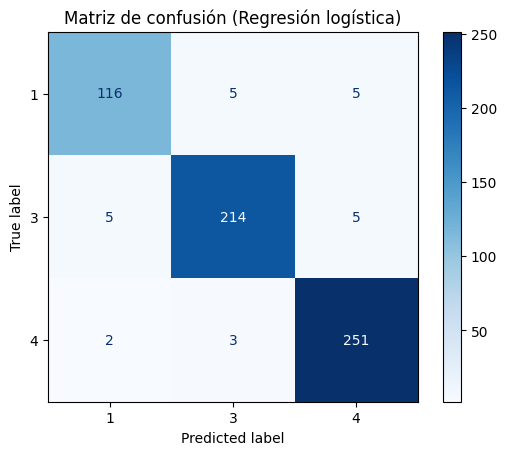

In [69]:
best_model = grid.best_estimator_

y_pred_rl = best_model.predict(X_test_rl)

print("\n===== Resultados finales con el mejor modelo =====")
print(classification_report(y_test, y_pred_rl, digits=4))

cm = confusion_matrix(y_test, y_pred_rl, labels=sorted(y_data.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_data.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de confusión (Regresión logística)")
plt.show()

Acto seguido al utilizar el mejor modelo seleccionado y ya entrenado del paso anterior se obtuvo que :

El modelo clasificó correctamente 116 textos de la clase 1, 214 de la clase 3 y 251 de la clase 4. Tuvo 10 falsos negativos de la clase 1 y 7 falsos positivos. De la clase 3 tuvo 10 falsos negativos y 8 falsos positivos. Para la clase 4 tuvo 5 falsos negativos y 10 falsos positivos.

En cuanto a las metricas, la clase mejor clasificada fue la 4 luego 3 y por ultimo la 1, al ser la que menos elementos tiene. En este caso se decidió utilizar class_weight='balanced' para balancear los pesos al tener un dataset desbalanceado.

##4.3 K-Vecinos más cercanos, realizado por Gabriela Zambrano

Para la evaluación del modelo KNN, se decide explorar en primer lugar el comportamiento del modelo con diferentes valores de k, para asi encontrar el mejor modelo posible.


===== Resultados para k=1 =====
              precision    recall  f1-score   support

           1     0.8235    0.8889    0.8550       126
           3     0.9387    0.8884    0.9128       224
           4     0.9264    0.9336    0.9300       256

    accuracy                         0.9076       606
   macro avg     0.8962    0.9036    0.8993       606
weighted avg     0.9095    0.9076    0.9080       606



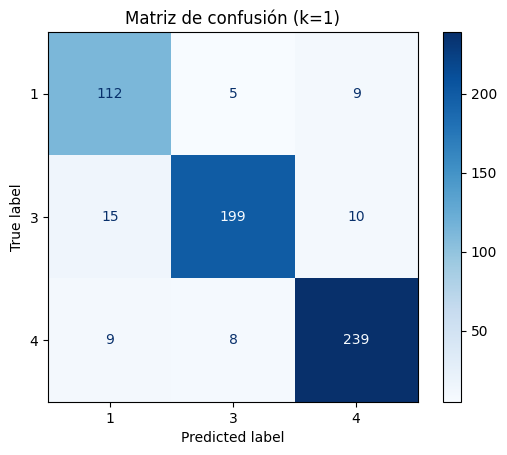


===== Resultados para k=3 =====
              precision    recall  f1-score   support

           1     0.8201    0.9048    0.8604       126
           3     0.9581    0.9196    0.9385       224
           4     0.9524    0.9375    0.9449       256

    accuracy                         0.9241       606
   macro avg     0.9102    0.9206    0.9146       606
weighted avg     0.9270    0.9241    0.9250       606



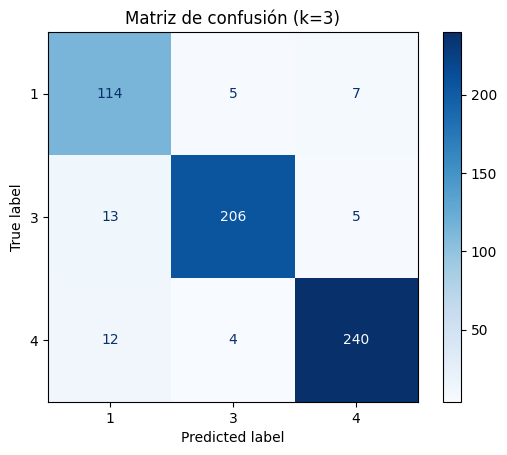


===== Resultados para k=5 =====
              precision    recall  f1-score   support

           1     0.8561    0.8968    0.8760       126
           3     0.9591    0.9420    0.9505       224
           4     0.9449    0.9375    0.9412       256

    accuracy                         0.9307       606
   macro avg     0.9200    0.9254    0.9225       606
weighted avg     0.9317    0.9307    0.9310       606



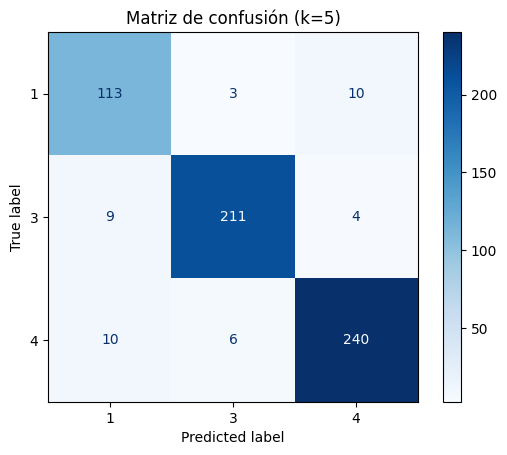


===== Resultados para k=7 =====
              precision    recall  f1-score   support

           1     0.9127    0.9127    0.9127       126
           3     0.9771    0.9509    0.9638       224
           4     0.9466    0.9688    0.9575       256

    accuracy                         0.9505       606
   macro avg     0.9454    0.9441    0.9447       606
weighted avg     0.9508    0.9505    0.9505       606



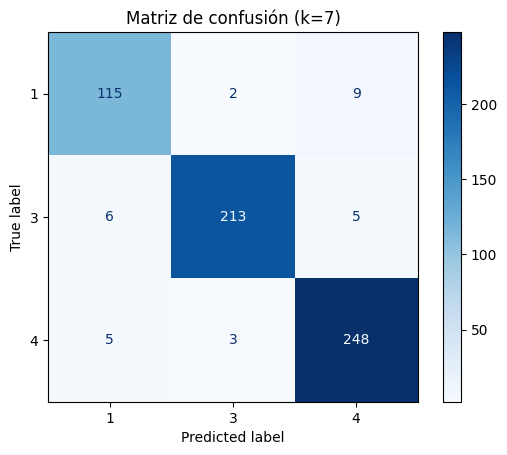


===== Resultados para k=9 =====
              precision    recall  f1-score   support

           1     0.8984    0.9127    0.9055       126
           3     0.9811    0.9286    0.9541       224
           4     0.9361    0.9727    0.9540       256

    accuracy                         0.9439       606
   macro avg     0.9386    0.9380    0.9379       606
weighted avg     0.9449    0.9439    0.9440       606



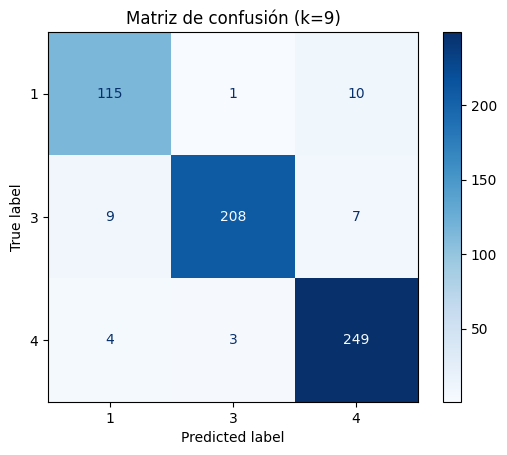


===== Resultados para k=11 =====
              precision    recall  f1-score   support

           1     0.9000    0.9286    0.9141       126
           3     0.9815    0.9464    0.9636       224
           4     0.9577    0.9727    0.9651       256

    accuracy                         0.9538       606
   macro avg     0.9464    0.9492    0.9476       606
weighted avg     0.9545    0.9538    0.9540       606



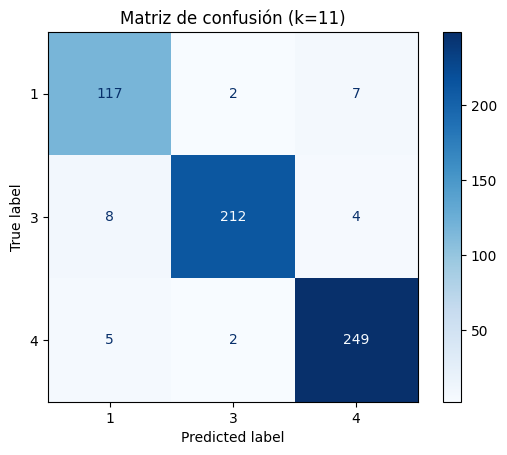


===== Resultados para k=15 =====
              precision    recall  f1-score   support

           1     0.8923    0.9206    0.9062       126
           3     0.9766    0.9330    0.9543       224
           4     0.9542    0.9766    0.9653       256

    accuracy                         0.9488       606
   macro avg     0.9410    0.9434    0.9419       606
weighted avg     0.9496    0.9488    0.9489       606



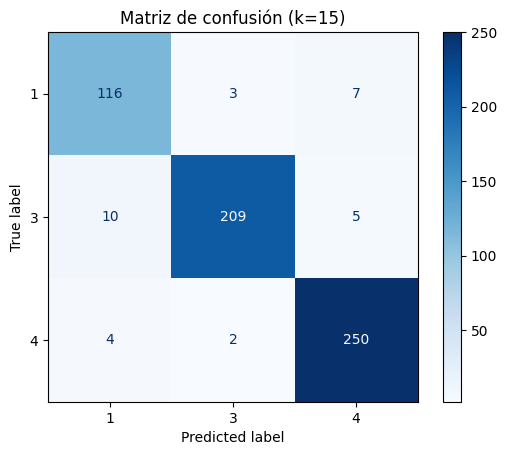

In [70]:

#generar copia X_train y X_test

X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

#Probar con varios valores de k, asi se puede escoger el mejor
k_values = [1, 3, 5, 7, 9, 11, 15]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train)
    y_pred = knn.predict(X_test_knn)

    #Reporte de clasificación
    print(f"\n===== Resultados para k={k} =====")
    print(classification_report(y_test, y_pred, digits=4))

    #matriz Confusión
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_data.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_data.unique()))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Matriz de confusión (k={k})")
    plt.show()

Luego de revisar las matrices de confusión y analizar los valores de precision, recall y F1-score, se encontró que los mejores resultados se obtuvieron con los valores de k = 7 y k = 11.

Los resultados que se obtuvieron con los dos valores son los siguientes:

* K=7

  * Accuracy: 0.9505

  * Precision: 0.9454

  * Recall: 0.9441

  * F1: 0.9447

* K=11

  * Accuracy: 0.9538

  * Precision: 0.9464

  * Recall: 0.9492

  * F1: 0.9476

Ambos k presentan un valor alto de accurancy, lo que indica que hay un buen equilibrio entre clases. Sin embargo, como se puede observar los valores de k=11 son mayores a los de k=7. La única diferencia que se encuentra es que con k=7 se obtuvo un mejor desempeño en el recall de la clase 3. A diferencia, de que con k=11ss e observó una mejora en la clase 4, sin embargo, se presentó una leve disminución en la clase 3. No obstante, ambos valores ofrecen un desempeño superior en comparación con otros valores probados, alcanzando altos niveles de exactitud y buen equilibrio entre las clases.

Se tomo la decisión de trabajar con un k=11, ya que los resultados de las metricas son levemente mayores a cuando k=7.


===== Resultados para k=11 =====
              precision    recall  f1-score   support

           1     0.9000    0.9286    0.9141       126
           3     0.9815    0.9464    0.9636       224
           4     0.9577    0.9727    0.9651       256

    accuracy                         0.9538       606
   macro avg     0.9464    0.9492    0.9476       606
weighted avg     0.9545    0.9538    0.9540       606



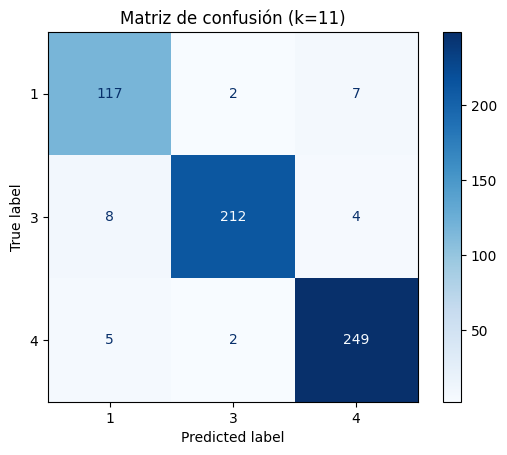

In [71]:
k=11

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_knn, y_train)
y_pred_knn = knn.predict(X_test_knn)

#Reporte de clasificación
print(f"\n===== Resultados para k={k} =====")
print(classification_report(y_test, y_pred_knn, digits=4))

#matriz Confusión
cm = confusion_matrix(y_test, y_pred_knn, labels=sorted(y_data.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_data.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Matriz de confusión (k={k})")
plt.show()

La matriz de confusión para KNN con k=11 evidencia un buen desempeño del modelo en la clasificación de las tres categorías. La clase 4 fue la mejor reconocida con 249 aciertos y solo 7 errores, mientras que la clase 3 alcanzó 212 clasificaciones correctas y 12 confusiones, principalmente con la clase 1. Por su parte, la clase 1 obtuvo 117 aciertos y 9 errores, con confusiones distribuidas entre las clases 3 y 4. En conjunto, los resultados muestran que el modelo logra una alta capacidad de predicción, aunque las clases 1 y 3 presentan un mayor nivel de confusión relativa en comparación con la clase 4.

##4.4 Multinomial Naïve Bayes, realizado por Maria Ines Velásquez






Considerando que se están contando las frecuencias de la aparición de las palabras en la matriz de datos, se elige usar el algoritmo clasificador multinomial naïve Bayes, que se encarga de clasificar teniendo en cuenta características discretas como es el caso. Para ello, primero se realiza una copia de los datos para evitar alterar los datos originales y después se implementa el algoritmo con un alpha de 5% elegido arbitrariamente.


===== Resultados =====
              precision    recall  f1-score   support

           1     0.9167    0.8730    0.8943       126
           3     0.9336    0.9420    0.9378       224
           4     0.9538    0.9688    0.9612       256

    accuracy                         0.9389       606
   macro avg     0.9347    0.9279    0.9311       606
weighted avg     0.9386    0.9389    0.9387       606



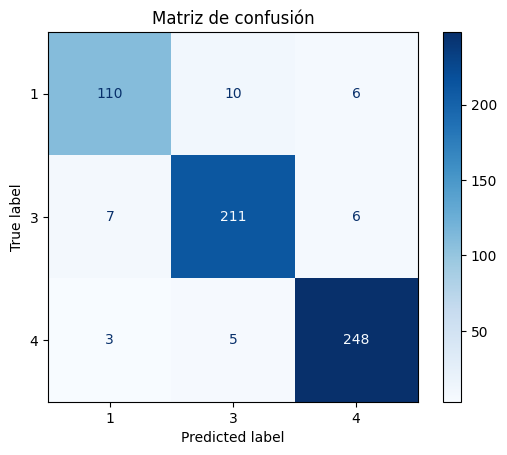

In [72]:
# Generar copia X_train y X_test

X_train_nb = X_train.copy()
X_test_nb = X_test.copy()

# Importar libreria de bayes
from sklearn.naive_bayes import MultinomialNB

# Generar clasificador
mnb = MultinomialNB(alpha=0.05)
mnb.fit(X_train_nb, y_train)
y_prednb = mnb.predict(X_test_nb)

# Reporte de clasificación
print(f"\n===== Resultados =====")
print(classification_report(y_test, y_prednb, digits=4))

# Matriz Confusión
cm = confusion_matrix(y_test, y_prednb, labels=sorted(y_data.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_data.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Matriz de confusión")
plt.show()

Al observar los resultados y la matriz de confusión, se puede decir que considerando la precisión, el recall y el f1 score, el modelo es capaz de clasificar correctamente los textos en un 94% aproximadamente. Esto se debe a que este modelo es muy confiable para determinar las clases 3 y 4 como se puede ver el f1-score individual de cada una, los cuales son superiores al 93%. NO obstante, se puede ver que el modelo tiene dificultades para identificar correctamente la clase 1 obteniendo un f1-score del 89%, lo cual no es ideal, pero es aceptable. Esto también puede verse influenciado por la cantidad de datos reales de esta clase que son menores en gran medida a los de las demás clases. En general, el modelo es bastante confiable, puesto que identifica correctamente el 94% de los textos, teniendo un rendimiento menor con la clase 1, donde se puede observar que 10 de los textos se confundieron con clase 3 y 6 con los clase 4.

# 5. Comparación de modelos

Los mejores resultados de cada modelo se pueden observar a continuación:


===== Resultados Regresión Logística =====
              precision    recall  f1-score   support

           1     0.9431    0.9206    0.9317       126
           3     0.9640    0.9554    0.9596       224
           4     0.9617    0.9805    0.9710       256

    accuracy                         0.9587       606
   macro avg     0.9562    0.9522    0.9541       606
weighted avg     0.9587    0.9587    0.9586       606


===== Resultados KNN =====
              precision    recall  f1-score   support

           1     0.9000    0.9286    0.9141       126
           3     0.9815    0.9464    0.9636       224
           4     0.9577    0.9727    0.9651       256

    accuracy                         0.9538       606
   macro avg     0.9464    0.9492    0.9476       606
weighted avg     0.9545    0.9538    0.9540       606


===== Resultados Naive Bayes =====
              precision    recall  f1-score   support

           1     0.9167    0.8730    0.8943       126
           3     0.93

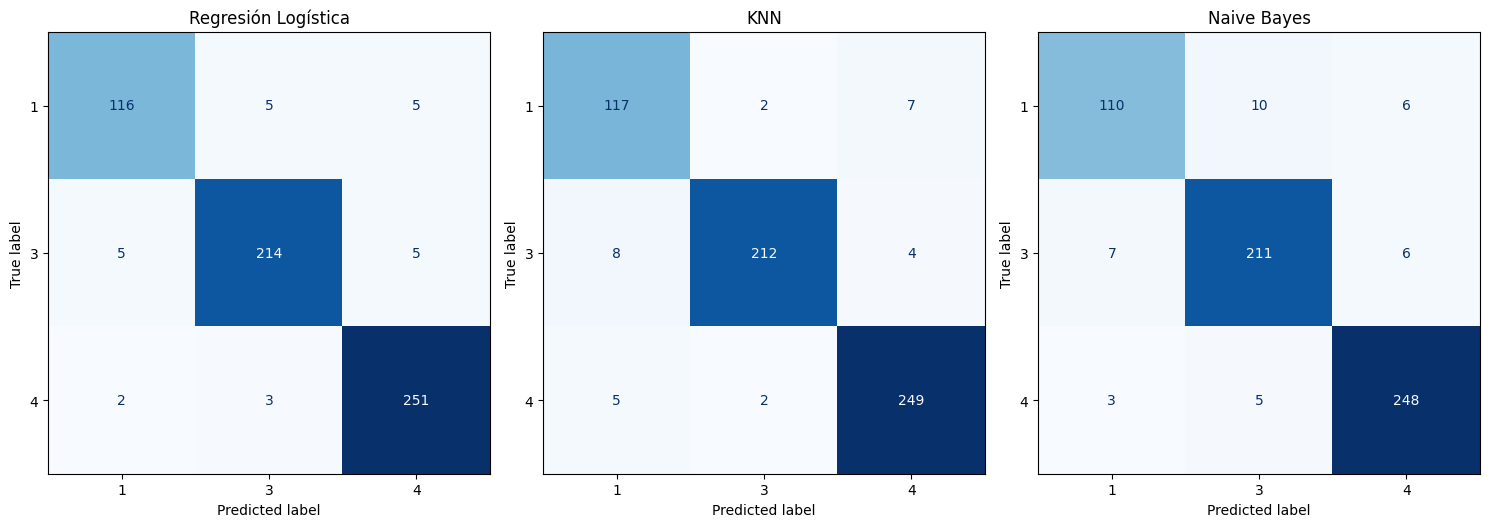

======================== Comparación métricas ==============================
                     Accuracy  Precision    Recall  F1-score
Regresión Logística  0.958746   0.958661  0.958746  0.958630
KNN                  0.953795   0.954490  0.953795  0.953954
Naive Bayes          0.938944   0.938643  0.938944  0.938651


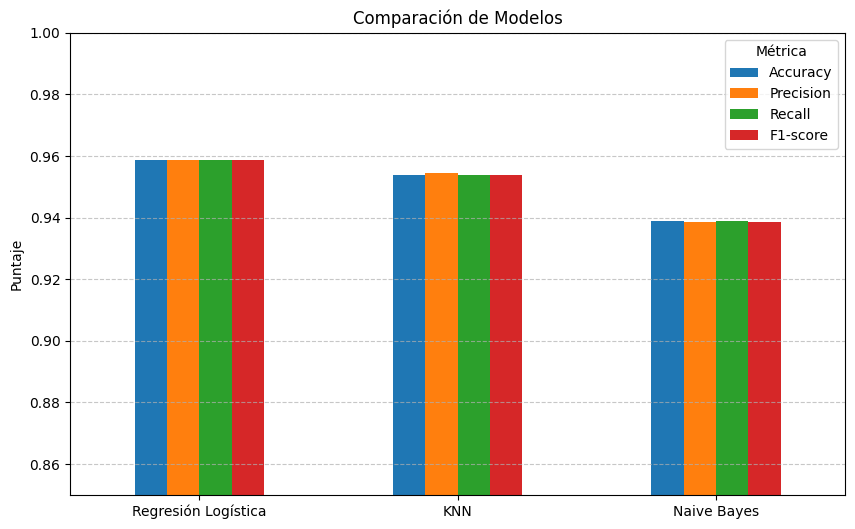

In [73]:
predicciones = {
    "Regresión Logística": y_pred_rl,
    "KNN": y_pred_knn,
    "Naive Bayes": y_prednb
}

metricas = {}

# Reportes de clasificación
for nombre, pred in predicciones.items():
  reporte = classification_report(y_test, pred, output_dict=True, digits=4)
  metricas[nombre] = {
      "Accuracy": reporte["accuracy"],
        "Precision": reporte["weighted avg"]["precision"],
        "Recall": reporte["weighted avg"]["recall"],
        "F1-score": reporte["weighted avg"]["f1-score"]}
  print(f"\n===== Resultados {nombre} =====")
  print(classification_report(y_test, pred, digits=4))

# Matrices de confusión en una fila
fig, axes = plt.subplots(1, len(predicciones), figsize=(15, 5))

for ax, (nombre, pred) in zip(axes, predicciones.items()):
    cm = confusion_matrix(y_test, pred, labels=sorted(y_data.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_data.unique()))
    disp.plot(cmap="Blues", values_format='d', ax=ax, colorbar=False)
    ax.set_title(f"{nombre}")

plt.tight_layout()
plt.show()

print("======================== Comparación métricas ==============================")

df_metricas = pd.DataFrame(metricas).T
print(df_metricas)

ax = df_metricas.plot(kind="bar", figsize=(10, 6))
plt.title("Comparación de Modelos")
plt.ylabel("Puntaje")
plt.ylim(0.85, 1.0)  # Ajusta el rango según tus valores
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Al analizar la comparación del rendimiento de los diferentes modelos, se seleccionó el modelo de ** Regresión Logística**, este obtuvo las métricas más altas en todas las áreas, destacando con un F1-score de 0.9586. Este fue la métrica que se priorizo para asegurar la selección de un modelo que balanceara correctamente tanto la Precisión como el Recall. Esto es fundamental cuando buscamos un buen rendimiento tanto en la correcta identificación de los textos de cada ODS como en evitar perder información relevante.

Debido a que los datos de entrenamiento no se encontraban balanceados, la métrica de Accuracy no puede ser tomada como una métrica que indique un ben rendimiento del modelo. Por este motivo se debe hacer un análisis de la matriz de confusión.  Esta muestra un rendimiento muy sólido del modelo de Regresión Logística, con un 95.87% de aciertos. La clase 4 es la mejor identificada, con solo 5 errores de 256 casos. En comparación con las clases 3 y 1, donde en la primera se logran 214 aciertos de 224 ejemplos. Del mismo modo, la clase 1 presenta el mismo número de confusiones relativas que la clase 3, ya que no se identificaron correctamente 10 comentarios de los 126 casos. Esto indica que, aunque el modelo clasifica con gran precisión las clases mayoritarias, la clase minoritaria resulta ligeramente más difícil de predecir.

Por otra parte, la Precisión (0.9587) indica cual es el porcentaje de predicciones correctas entre todas las instancias que el modelo etiqueto como pertenecientes a una categoría en particular. En este caso se obtuvo que el 95.87% de los textos que fueron clasificados, fueron clasificados correctamente en las diferentes categorías de los ODS 1,3 o 4. Este valor es importante en escenarios donde los falsos positivos son costosos, sin embargo, en nuestro caso era necesario asegurar que no dejáramos de identificar textos relevantes.

Por ello, el Recall (0.9587) constituye una métrica clave para analizar el rendimiento del modelo. Este mide la capacidad de identificar la mayor cantidad posible de instancias positivas dentro de cada categoría. Esto significa que el modelo fue capaz de recuperar el 95.87% de los comentarios que efectivamente pertenecían a las categorías ODS 1, 3, o 4, reduciendo al mínimo la pérdida de información importante.

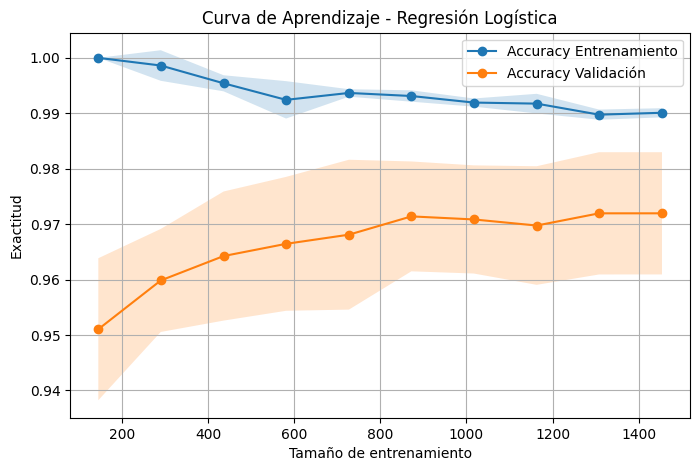

In [74]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    best_model,           # tu modelo entrenado
    X_train, y_train,    # datos de entrenamiento
    cv=5,                # validación cruzada
    scoring='accuracy',  # métrica
    train_sizes=np.linspace(0.1, 1.0, 10),  # de 10% a 100% de los datos
    n_jobs=-1
)

# Calcular promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Accuracy Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Accuracy Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Exactitud")
plt.title("Curva de Aprendizaje - Regresión Logística")
plt.legend()
plt.grid()
plt.show()


Con la grafica anterior podemos ver que no hay sobreajuste en nuestro mejor modelo.

# 6. Resultados del mejor modelo

Se realiza el análisis cualitativo y cuantitativo a partir del mejor modelo, que corresponde a una Regresión Logística. Para ello, se obtienen los atributos relevantes de la regresión (que corresponderán a las palabras tokenizadas) para cada una de las clases junto con sus coeficientes.

## Analisis de palabras cuantitativo

Para este analisis se generó una tabla con la palabra y el coeficiente, asi como una grafica ilustrativa con esta misma informacion para mayor comprension, esto se realizó pra cada clase.

Cabe resaltar que se van a mostrar solo las 20 palabras de menor y mayor coeficiente. Es decir, en la mitad pueden haber muchas más palabras que son procesadas y modeladas con un determinado coeficiente de regresión intermedio.

In [75]:

# --- 1. Crear el dataframe con palabras y coeficientes ---
palabras = np.array(tfidf.get_feature_names_out())
coeficientes = best_model.coef_

# Construimos un dataframe con todas las palabras y sus coeficientes por clase
df_palabras = pd.DataFrame(coeficientes.T, index=palabras, columns=best_model.classes_)

# --- 2. Crear un mini dataframe por clase ---
mini_df_por_clase = {
    clase: pd.DataFrame({
        "palabra": df_palabras.index,
        "coeficiente": df_palabras[clase]
    }).sort_values("coeficiente", ascending=False)
    for clase in df_palabras.columns
}



def mostrar_df_estilizado_compacto(df, n=10):

    # Selecciona top n y bottom n por coeficiente
    df_top_bottom = pd.concat([df.head(n), df.tail(n)]).sort_values("coeficiente", ascending=False)

    # Crear DataFrame compacto: palabras como columnas
    df_compacto = pd.DataFrame(
        [df_top_bottom["palabra"].values, df_top_bottom["coeficiente"].values],
        index=["Palabra", "Coeficiente"]
    )

    # Aplicar estilo: solo a la fila de coeficientes
    return df_compacto.style.background_gradient(
        subset=pd.IndexSlice["Coeficiente", :]
    ).set_properties(**{
        'text-align': 'center',
        'font-size': '12pt'
    })





### Clase 1: Fin de la pobreza

Para la clase 1 que corresponde al objetivo 1 de desarrollo sostenible se obtuvó que las palabras mas importantes (tanto de forma positiva como negativa) para el modelo fueron :



In [76]:
clase_ejemplo1 = list(mini_df_por_clase.keys())[0]
mostrar_df_estilizado_compacto(mini_df_por_clase[clase_ejemplo1], n=10)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Palabra,pobreza,pobre,hogar,ingreso,pobrezar,social,privación,niño,infantil,umbral,aprendizaje,paciente,estudiant,ocde,docente,médico,educación,atención,escuela,salud
Coeficiente,2.283061,1.190819,0.975017,0.963627,0.904959,0.649225,0.579625,0.485577,0.442208,0.412538,-0.359539,-0.361518,-0.370063,-0.395612,-0.407582,-0.436871,-0.458008,-0.578806,-0.622070,-0.685222


Ahora bien se hizo una grafica para ver mas claramente la importancia de estas palabras:

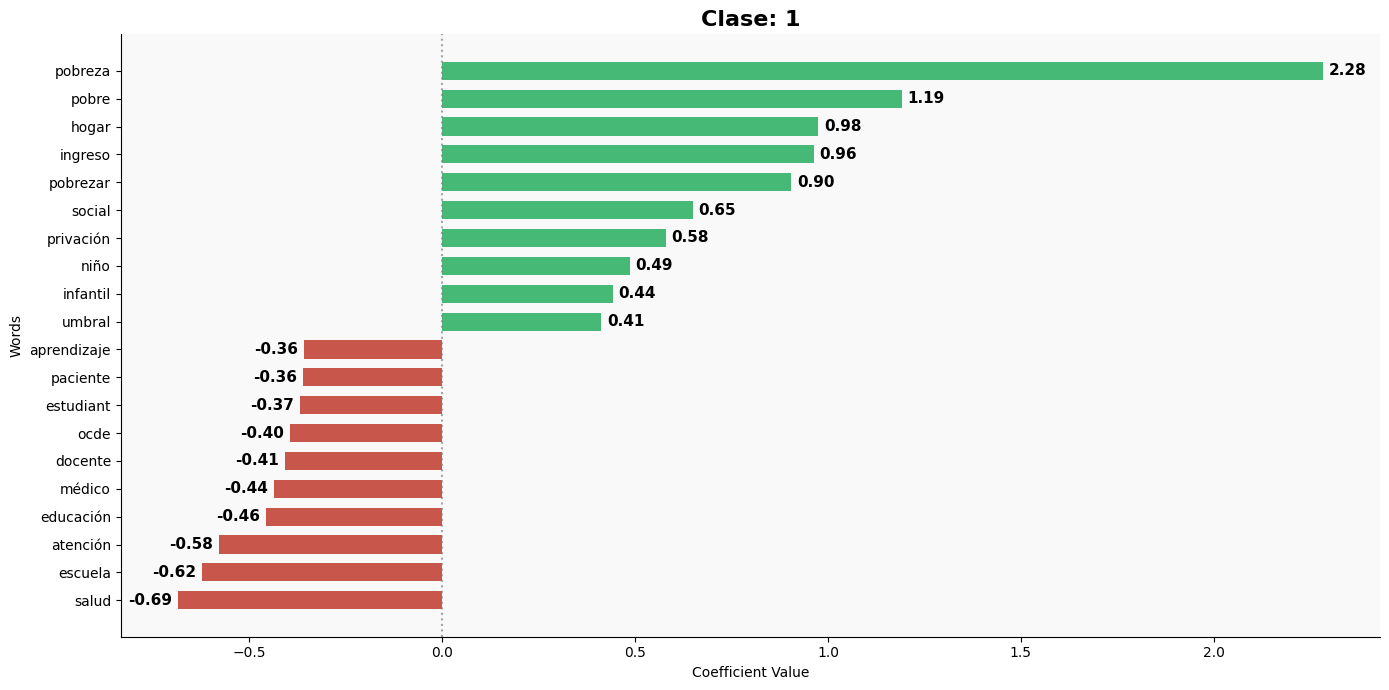

In [77]:


clase = list(mini_df_por_clase.keys())[0]
df = mini_df_por_clase[clase]

plt.figure(figsize=(14, 7))

top_bottom = pd.concat([df.head(10), df.tail(10)]).sort_values("coeficiente", ascending=False)

colores = ["#27ae60" if v > 0 else "#c0392b" for v in top_bottom["coeficiente"]]
barras = plt.barh(top_bottom["palabra"], top_bottom["coeficiente"],
                  color=colores, alpha=0.85, height=0.65)

for bar, valor in zip(barras, top_bottom["coeficiente"]):
    plt.text(bar.get_width() + (0.015 if valor > 0 else -0.015),
             bar.get_y() + bar.get_height()/2,
             f"{valor:.2f}",
             va='center',
             ha='left' if valor > 0 else 'right',
             fontsize=11, fontweight="bold")

plt.axvline(x=0, color="gray", linestyle=":", alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title(f"Clase: {clase}", fontsize=16, fontweight="bold")
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.ylabel('Words')

plt.tight_layout()
plt.show()




En la grafica podemos ver que las 3 primeras palabras fueron las mas importantes de todas las 20 palabras. Estas corresponden a "pobreza" (2.28) y  "pobre"(1.19), al analizar esto es evidente que son las mas relacionadas con los el ODS 1 "fin de la probreza".

- Positivas
  En cuanto a las palabras con barras verdes, al tener coeficientes positivos, esto indica que su codificación tiene un efecto positivo sobre el modelo de regresión logística. La magnitud de los coeficientes refleja la fuerza de la asociación entre estas palabras y la clase 1, lo que permite al modelo hacer predicciones más precisas y coherentes en función de la información textual proporcionada.

  Es decir, un texto que tiene las palabras "pobreza" y "pobre" va a tender a ser clasificado como parte de la clase 1, más por la presencia de la palabra "pobreza" que por la presencia de la palabra "pobre". En cuanto a las demas, estas puedas contribuir para clasificar esta clase al estar relacionado con las dificultades debido a la pobreza como la "privación" de diversos beneficios.Ademas, pueden ser palabras que representan las razones de la pobreza como un bajos "ingresos".


- Negativas
  Así como los coeficientes positivos indican un efecto positivo sobre el valor de la regresión logística, los coeficientes de regresión negativos indican lo contrario, palabras cuya presencia reduce la probabilidad de que el texto sea de la categoría 3. Las mas significativas son "salud"(-0.69), "escuela" (-0.62),
  "atención" (-0.58), lo que podria ser sustantivos que representan cosas a la cuales no tienen acceso las personas que sufren de pobreza. Sin embargo, el efecto de estos no es tan significativo como los primeros 3 positivos.



  Asimismo, las demas palabras tambien se relacion con el area de la salud como "atención" y "sanitario", lo que podria indicar que es poco probable que las opiniones que tengan este enfoque sean clasificadas como clase 1.Lo mismo ocurre con el ambito educativo como "estudiant","aprendizaje" y "educativo".

Esto tiene sentido en vista de que dichas palabras se asocian más a los otros ODS (3: Salud y bienestar y 4: Educación de Calidad ). Las demás palabras que tienen efectos negativos más fuertes sobre esta clasificación se muestran en el gráfico con las barras de color rojo.

### Clase 3: Salud y bienestar
Para la clase 3 que corresponde al objetivo 3 de desarrollo sostenible se obtuvó que las palabras mas importantes (tanto de forma positiva como negativa) para el modelo fueron :


In [78]:
clase_ejemplo3 = list(mini_df_por_clase.keys())[1]
mostrar_df_estilizado_compacto(mini_df_por_clase[clase_ejemplo3], n=10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Palabra,salud,atención,médico,paciente,enfermedad,sanitario,mental,servicio,hospital,tratamiento,educativo,niño,escolar,pobrezar,hogar,docente,pobre,escuela,educación,pobreza
Coeficiente,1.592995,1.206259,0.935203,0.787121,0.700936,0.670195,0.669890,0.541552,0.469225,0.462155,-0.421792,-0.440109,-0.456043,-0.470491,-0.475205,-0.484414,-0.630814,-0.679987,-0.762171,-1.180169


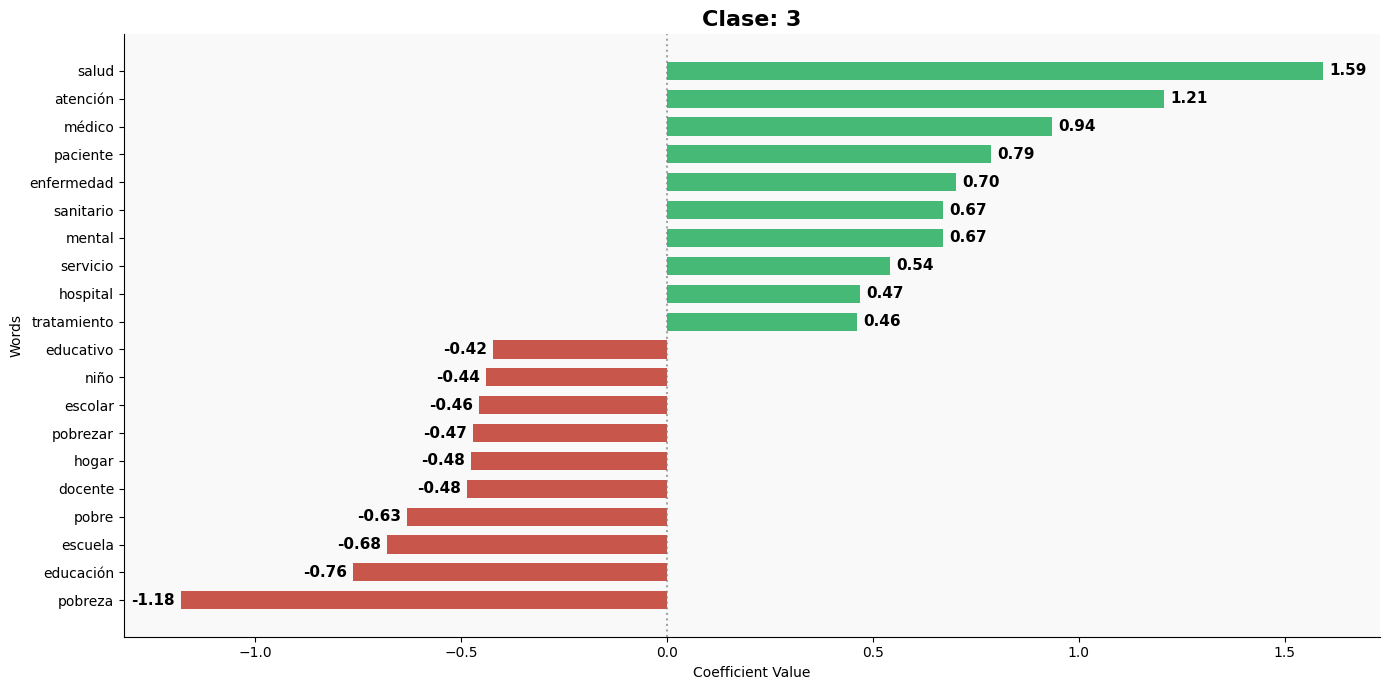

In [79]:
clase = list(mini_df_por_clase.keys())[1]
df = mini_df_por_clase[clase]

plt.figure(figsize=(14, 7))

top_bottom = pd.concat([df.head(10), df.tail(10)]).sort_values("coeficiente", ascending=False)

colores = ["#27ae60" if v > 0 else "#c0392b" for v in top_bottom["coeficiente"]]
barras = plt.barh(top_bottom["palabra"], top_bottom["coeficiente"],
                  color=colores, alpha=0.85, height=0.65)

for bar, valor in zip(barras, top_bottom["coeficiente"]):
    plt.text(bar.get_width() + (0.015 if valor > 0 else -0.015),
             bar.get_y() + bar.get_height()/2,
             f"{valor:.2f}",
             va='center',
             ha='left' if valor > 0 else 'right',
             fontsize=11, fontweight="bold")

plt.axvline(x=0, color="gray", linestyle=":", alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title(f"Clase: {clase}", fontsize=16, fontweight="bold")
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.ylabel('Words')

plt.tight_layout()
plt.show()



En la grafica podemos ver que la primera palabra fue la mas importante de todas las 20 palabras. Esta corresponde a "salud" (1.59), lo que es bastante predecible al tratarse del ODS 3 "Salud y Bienestar".

- Positivas

  En cuanto a las palabras con barras verdes,al tener coeficientes positivos, esto indica que su codificación tiene un efecto positivo sobre el modelo de regresión logística. La magnitud de los coeficientes refleja la fuerza de la asociación entre estas palabras y la clase 3, lo que permite al modelo hacer predicciones más precisas y coherentes en función de la información textual proporcionada.

  Es decir, un texto que tiene las palabras "salud" y "medico" va a tender a ser clasificado como parte de la clase 3, más por la presencia de la palabra "salud" que por la presencia de la palabra "medico". En cuanto a las demas, estas puedas contribuir para clasificar esta clase al estar relacionado con el area de la salud como "hospital", "paciente" y "tratamiento". Asi como, palabras relacionadas con aspectos que pueden afectar tu bienestar como "enfermedad" y "mental" (relacionado posiblemente con salud mental).

- Negativas

  Así como los coeficientes positivos indican un efecto positivo sobre el valor de la regresión logística, los coeficientes de regresión negativos indican lo contrario, palabras cuya presencia reduce la probabilidad de que el texto sea de la clase 3. Las mas significativas son "pobreza"(-1.18), "educación" (-0.76),
  "escuela" (-0.68), con estas podemos ver que 1 de estas palabras fue la mas significativa para clasificar las opiniones de la clase 1.





  Por otro lado, las demas palabras tambien se relacion con el ambito educativo como "escuela","educación" y "docente".Lo que podria indicar que es poco probable que las opiniones que tengan este enfoque sean clasificadas como clase 3.

Esto tiene sentido en vista de que dichas palabras se asocian más a los otros ODS (1: Fin de la pobreza y 4: Educación de Calidad ). Las demás palabras que tienen efectos negativos más fuertes sobre esta clasificación se muestran en el gráfico con las barras de color rojo.

### Clase 4: Educación de calidad
Para la clase 4 que corresponde al objetivo 4 de desarrollo sostenible se obtuvó que las palabras mas importantes (tanto de forma positiva como negativa) para el modelo fueron :

In [80]:
clase_ejemplo4 = list(mini_df_por_clase.keys())[2]
mostrar_df_estilizado_compacto(mini_df_por_clase[clase_ejemplo4], n=10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Palabra,escuela,educación,docente,educativo,aprendizaje,estudiant,escolar,alumno,estudiante,evaluación,servicio,paciente,pobrezar,médico,hogar,pobre,ingreso,atención,salud,pobreza
Coeficiente,1.302057,1.220179,0.891996,0.776226,0.772382,0.769417,0.752295,0.672042,0.585396,0.573686,-0.394259,-0.425603,-0.434469,-0.498331,-0.499812,-0.560004,-0.563787,-0.627452,-0.907772,-1.102892


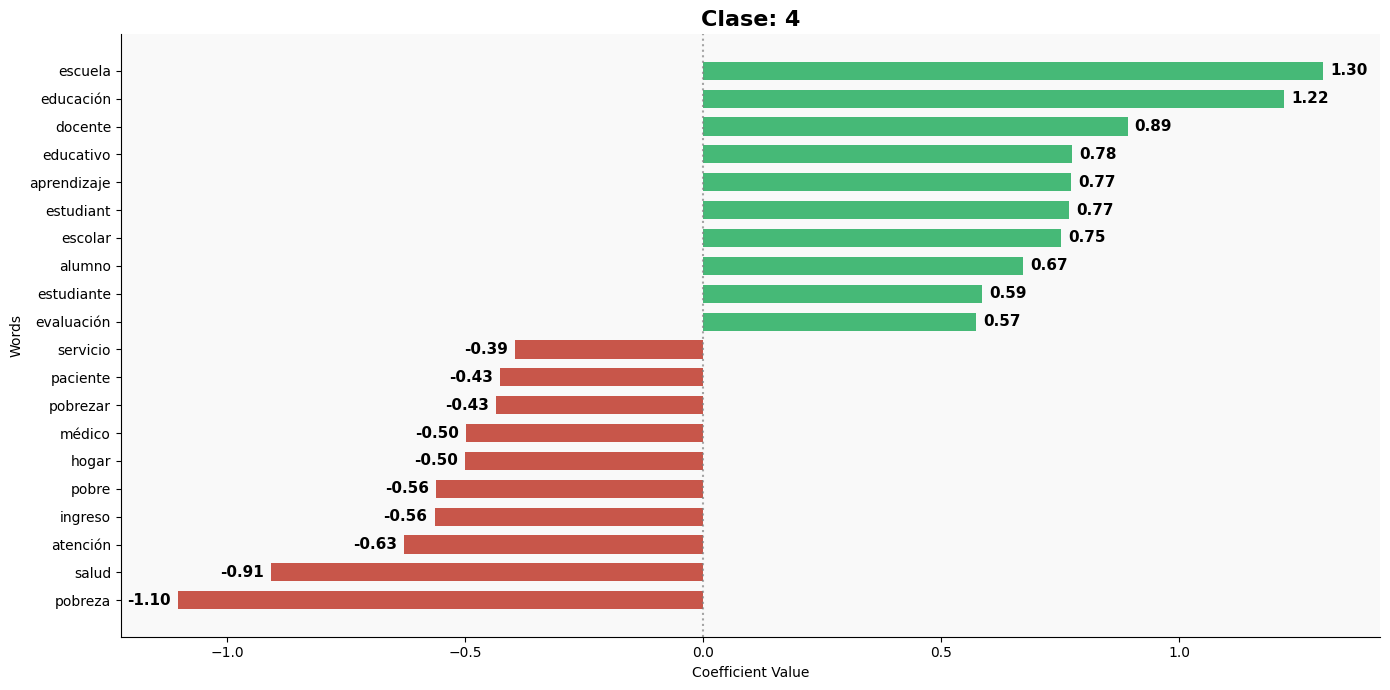

In [81]:
clase = list(mini_df_por_clase.keys())[2]
df = mini_df_por_clase[clase]

plt.figure(figsize=(14, 7))

top_bottom = pd.concat([df.head(10), df.tail(10)]).sort_values("coeficiente", ascending=False)

colores = ["#27ae60" if v > 0 else "#c0392b" for v in top_bottom["coeficiente"]]
barras = plt.barh(top_bottom["palabra"], top_bottom["coeficiente"],
                  color=colores, alpha=0.85, height=0.65)

for bar, valor in zip(barras, top_bottom["coeficiente"]):
    plt.text(bar.get_width() + (0.015 if valor > 0 else -0.015),
             bar.get_y() + bar.get_height()/2,
             f"{valor:.2f}",
             va='center',
             ha='left' if valor > 0 else 'right',
             fontsize=11, fontweight="bold")

plt.axvline(x=0, color="gray", linestyle=":", alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title(f"Clase: {clase}", fontsize=16, fontweight="bold")
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.ylabel('Words')

plt.tight_layout()
plt.show()


En la grafica podemos ver que las 3 primeras palabras fue las mas importantes de todas las 20 palabras. Esta corresponde a "escuela" (1.30),"educación" (1.22), "docente" (0.89) lo que es bastante predecible al tratarse del ODS 4 "Educación de calidad".

- Positivas

  En cuanto a las palabras con barras verdes,al tener coeficientes positivos, esto indica que su codificación tiene un efecto positivo sobre el modelo de regresión logística. La magnitud de los coeficientes refleja la fuerza de la asociación entre estas palabras y la clase 4, lo que permite al modelo hacer predicciones más precisas y coherentes en función de la información textual proporcionada.

  Es decir, un texto que tiene las palabras "educación" y "escuela" va a tender a ser clasificado como parte de la clase 4, más por la presencia de la palabra "escuela" que por la presencia de la palabra "educación". En cuanto a las demas, estas puedas contribuir para clasificar esta clase al estar relacionado con el ambito educativo como "docente","escolar" y "aprendizaje".Los coeficiente de estas palabras son muy similares, pues la mayoria de estas palabras pueden llegar a tener la misma importancia al estar muy relacionadas, variando entre un rango de 0.5-0.9.


- Negativas

  Así como los coeficientes positivos indican un efecto positivo sobre el valor de la regresión logística, los coeficientes de regresión negativos indican lo contrario, palabras cuya presencia reduce la probabilidad de que el texto sea de la clase 4. Las mas significativas son "pobreza"(-1.10) y "salud" (-0.91) con estas podemos ver que son las palabras mas representativas para las dos clases anteriores.


  En cuanto a las demas palabras tambien se relacionan con el area de la salud como "atención","medico" y "paciente".Lo que podria indicar que es poco probable que las opiniones que tengan este enfoque sean clasificadas como clase 3.

Esto tiene sentido en vista de que dichas palabras se asocian más a los otros ODS (1: Fin de la pobreza y 3: Salud y Bienestar ). Las demás palabras que tienen efectos negativos más fuertes sobre esta clasificación se muestran en el gráfico con las barras de color rojo.

## Analisis palabras cualitativo

A continuación se ven las palabras mas significativas para cada clase incluyendo las que aportan para que sea asignada a esa clase, como las que evitan que sea asignada a esa clase.

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

def generar_wordcloud_desde_df(df, n=10, titulo="Nube de palabras"):
    """
    Genera una nube de palabras basada en un DataFrame de palabras y coeficientes.

    df     : DataFrame con columnas ['palabra', 'coeficiente']
    n      : número de palabras superiores e inferiores a usar
    titulo : título de la gráfica
    """
    # Seleccionar top n y bottom n según coeficiente
    df_top_bottom = pd.concat([df.head(n), df.tail(n)]).sort_values("coeficiente", ascending=False)

    # Crear diccionario palabra: importancia absoluta
    word_importances = {word: abs(coef) for word, coef in zip(df_top_bottom["palabra"], df_top_bottom["coeficiente"])}

    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importances)

    # Mostrar la nube
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()




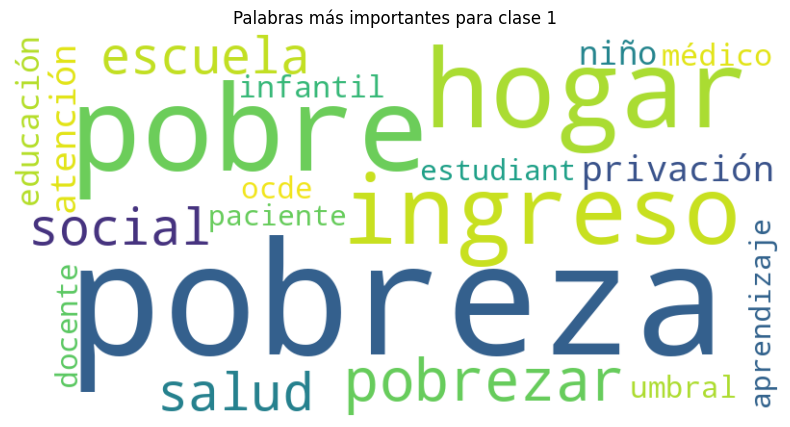

In [83]:
df1 = mini_df_por_clase[clase_ejemplo1]
generar_wordcloud_desde_df(df1, n=10, titulo=f"Palabras más importantes para clase {clase_ejemplo1}")

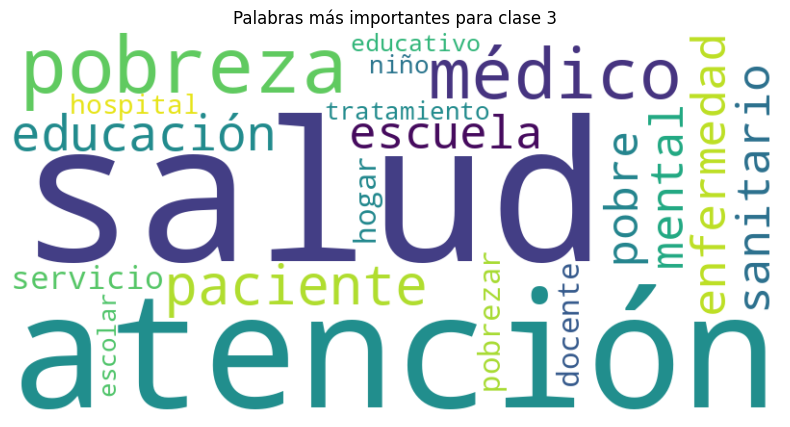

In [84]:
df3 = mini_df_por_clase[clase_ejemplo3]
generar_wordcloud_desde_df(df3, n=10, titulo=f"Palabras más importantes para clase {clase_ejemplo3}")

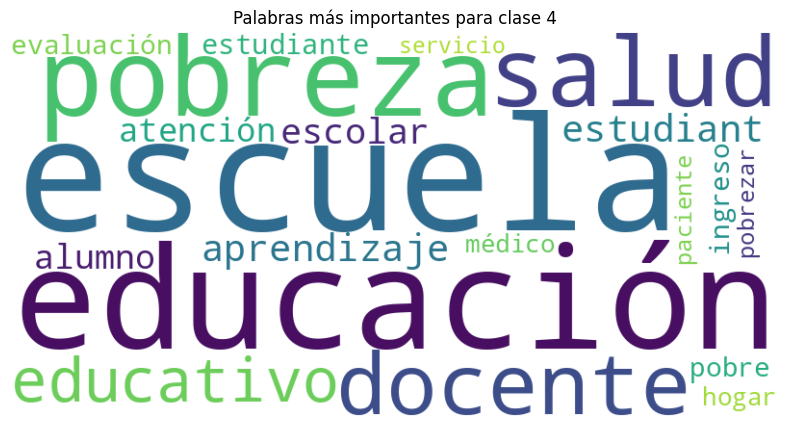

In [85]:
df4 = mini_df_por_clase[clase_ejemplo4]
generar_wordcloud_desde_df(df4, n=10, titulo=f"Palabras más importantes para clase {clase_ejemplo4}")

# 7 Generación de predicciones

In [90]:
validation_data = data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/BI/proyecto 1/Datos de prueba_proyecto.xlsx")
#validation_data = data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/BI/Datos de prueba_proyecto.xlsx")

validation_pipeline = validation_data.copy()

In [92]:
def pipeline_datos(df: pd.DataFrame):
    # Copia del DataFrame
    df_pipeline = df.copy()

    # Tokenización
    df_pipeline['words'] = df_pipeline['Textos_espanol'].apply(word_tokenize)

    # Preprocesamiento
    df_pipeline['words1'] = df_pipeline['words'].apply(preprocessing)

    # Lematización
    df_pipeline['words2'] = df_pipeline['words1'].apply(lemmatize)

    # Unir palabras en un solo string
    df_pipeline['words3'] = df_pipeline['words2'].apply(lambda x: ' '.join(map(str, x)))

    # Vectorización TF-IDF
    X_datos = tfidf.transform(df_pipeline['words3'])

    return X_datos


In [93]:
X_validation = pipeline_datos(validation_pipeline)
predicciones = best_model.predict(X_validation)

predicciones_df = pd.DataFrame({'Etiqueta Asignada': predicciones})
respuesta_df = pd.concat([validation_pipeline['Textos_espanol'], predicciones_df], axis=1)
respuesta_df

,Textos_espanol,Etiqueta Asignada
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4
...,...,...
147,"En Croacia, Grecia y Rumanía, 1 de cada 3 niño...",1
148,El informe también es una adición oportuna a l...,1
149,"Además, de los 1200 millones que salieron de l...",1
150,Aunque el porcentaje de población en situación...,1


In [94]:
# Exportar a un archivo en formato Excel
respuesta_df.to_excel('predicciones.xlsx', index=False)
# Exportar a un archivo en formato CSV por si las moscas
respuesta_df.to_csv('predicciones.csv', index=False)
